In [1]:
from model.model_initialization import * 
a = initialize_model([1000000, 1500000, 2000000], 10, 0.01, 0.02)

In [2]:
a

{'cfmm_type': '',
 'initial_values': {'token_list': ['R1', 'R2', 'R3'],
  'R': [1000000, 1500000, 2000000],
  'P': [2, 0.6666666666666666, 1],
  'fee_assets': 0.01,
  'fee_HDX': 0.02},
 'agent_d': {'Trader': {'HDX': 1000000,
   'R1': 1000000,
   'R2': 1000000,
   'R3': 1000000},
  'LP1': {'omniR1': 1000000},
  'LP2': {'omniR2': 1500000},
  'LP3': {'omniR3': 2000000}},
 'action_ls': [('trade', 1000)],
 'prob_dict': {'trade': {'sell_r2_for_r1': 0, 'sell_r1_for_r2': 1}},
 'action_dict': {'sell_r2_for_r1': {'token_buy': 'R1',
   'token_sell': 'R2',
   'amount_sell': 10,
   'action_id': 'Trade',
   'agent_id': 'Trader'},
  'sell_r1_for_r2': {'token_sell': 'R1',
   'token_buy': 'R2',
   'amount_sell': 10,
   'action_id': 'Trade',
   'agent_id': 'Trader'}}}

In [3]:
a.get('action_ls')[0][1]

1000

In [4]:
b = a['action_ls']

In [5]:
a['action_ls']

[('trade', 1000)]

In [6]:
#########################################################
#           import of packages & dependencies
#########################################################
import pandas as pd

from IPython.core.debugger import Pdb
ipdb = Pdb()

from model import init_utils
from model import processing
# Experiments
from model import run
from model.plot_utils import *
from model.model_initialization import * 

import numpy as np
import seaborn as sns
import matplotlib.pylab as plt


#########################################################
#     setting of experiment variables & parameters
#########################################################


fee_level_assets = (0.00, 0.01, 0.02, 0.03, 0.04)
fee_level_hdx = 0.00
# uniform_data = np.random.rand(10, 12)
#trade_volume = {'10': 0.5, '20': 0.6}
#liquidity = {'1000': 0.5, '2000': 0.6}
#trade_volume = (50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000)
#liquidity = (100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000)
trade_volume = [100, 110, 120]
liquidity_providers = [1000000, 1500000, 2000000]
sim_nr = 0
performance_of_agent = 'LP2'


if performance_of_agent == 'LP1':
    asset_of_agent = 'omniR1'
elif performance_of_agent == 'LP2':
    asset_of_agent = 'omniR2'
elif performance_of_agent == 'LP3':
    asset_of_agent = 'omniR3'

#########################################################
#     preparation of empty result matrix
#########################################################

m=len(trade_volume)
n=len(fee_level_assets)
matrix = np.ndarray(shape = (m,n), dtype = int)
matrix1 = np.ndarray(shape = (m,n), dtype = int)
matrix_ror = np.ndarray(shape = (m,n), dtype = int)
matrix_ror1 = np.ndarray(shape = (m,n), dtype = int)


#########################################################
#     repeated simulation runs with above parameters
#########################################################


for i in range(len(fee_level_assets)):
    for j in range(len(trade_volume)):
        #########################################################
        # initialize model with starting conditions for each run
        #########################################################
        
        config_params = initialize_model(liquidity_providers, trade_volume[j], fee_level_assets[i], fee_level_hdx)
        
        #########################################################
        # run model with above initialization
        #########################################################
        
        config_dict, state = init_utils.get_configuration(config_params)

        pd.options.mode.chained_assignment = None  # default='warn'
        pd.options.display.float_format = '{:.2f}'.format
        
        run.config(config_dict, state)
        events = run.run()
        
        rdf, agent_df = processing.postprocessing(events)

        #########################################################
        # calculate profitability metrics; change in pool values
        #########################################################
        
         
        print(sim_nr)
        total_timesteps = config_params.get('action_ls')[0][1] #grabbing the same total timestep as through initialize_model
        #total_timesteps = 1000
        first_timestep = 1
        print(total_timesteps)
        
        ## merge agent and pool dataframes
        profit_results = pd.merge(agent_df, rdf, how="inner", on=["timestep", "simulation", "run", "subset", "substep"])
        
        ## assign additional columns
        profit_results['val_pool'] = profit_results.apply(lambda x: processing.val_pool(x), axis=1)
        initial_values = config_params['initial_values']
        agent_d = config_params['agent_d']
        withdraw_agent_d = processing.get_withdraw_agent_d(initial_values, agent_d)
        print(withdraw_agent_d)
        profit_results['val_hold'] = profit_results.apply(lambda x: processing.val_hold(x, withdraw_agent_d), axis=1)
        #profit_results['IL'] = profit_results.apply(lambda x: x['val_pool']/x['val_hold'] - 1, axis=1)
        profit_results['pool_val'] = profit_results.apply(lambda x: processing.pool_val(x), axis=1)
        
        ## calculate profits from 'val_pool' and 'pool_val'        
        profit_results1 = profit_results[profit_results['simulation'] == sim_nr]
        profit_results2 = profit_results1[profit_results1['timestep'] == total_timesteps]
        profit_results3 = profit_results1[profit_results1['timestep'] == first_timestep]
        profit_results4 = profit_results2[profit_results2['agent_label'] == performance_of_agent] #define selection for final timestep for desired agent (LP1 / LP2 / ??)
        profit_results5 = profit_results3[profit_results3['agent_label'] == performance_of_agent] #define selection for first timestep for desired agent (LP1 / LP2 / ??)
        profit_sim0 = profit_results4['val_pool'].iloc[0] - profit_results5['val_pool'].iloc[0] # changed to 4 - 5 inst. of 2 - 3
        profit_sim1 = profit_results4['pool_val'].iloc[0] - profit_results5['pool_val'].iloc[0] # changed to 4 - 5 inst. of 2 - 3
        
        #backup (can be commented out)
        #profit_sim0 = profit_results2['val_pool'].iloc[0] - profit_results3['val_pool'].iloc[0] # changed to 4 - 5 inst. of 2 - 3
        #profit_sim1 = profit_results2['pool_val'].iloc[0] - profit_results3['pool_val'].iloc[0] # changed to 4 - 5 inst. of 2 - 3
        
        ## calculate 'rate of return' in basispoints
        ror0 = (profit_sim0 / agent_d[performance_of_agent][asset_of_agent]) * 10000
        ror1 = (profit_sim1 / agent_d[performance_of_agent][asset_of_agent]) * 10000
                    
        #########################################################
        # assign metrics (profit, ror) to empty matrix
        #########################################################
        
        #matrix[j][i] = np.random.randint(1, 100 + 1)
        #matrix[j][i] = trade_volume[i]*liquidity[j]
        matrix[j][i] = profit_sim0
        matrix1[j][i] = profit_sim1
        matrix_ror[j][i] = ror0
        matrix_ror1[j][i] = ror1
        
        #########################################################
        ## increase simulation count
        #########################################################
        
        sim_nr += 1




                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (1000, 3, 1, 3)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 0.61s
0
1000
{'Trader': {'q': 1000000, 's': [0, 0, 0], 'r': [1000000, 1000000, 1000000], 'p': [0, 0, 0]}, 'LP1': {'q': 0.0, 's': [0, 0, 0], 'r': [1000000.0, 0, 0], 'p': [2.0, 0, 0]}, 'LP2': {'q': 0.0, 's': [0, 0, 0], 'r': [0, 1500000.0, 0], 'p': [0, 0.6666666666666666, 0]}, 'LP3': {'q': 0.0, 's': [0, 0, 0], 'r': [0, 0, 2000000.0], 'p': [0, 0, 1.0]}}

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___

Total execution time: 7.85s
9
1000
{'Trader': {'q': 1000000, 's': [0, 0, 0], 'r': [1000000, 1000000, 1000000], 'p': [0, 0, 0]}, 'LP1': {'q': 0.0, 's': [0, 0, 0], 'r': [1000000.0, 0, 0], 'p': [2.0, 0, 0]}, 'LP2': {'q': 0.0, 's': [0, 0, 0], 'r': [0, 1500000.0, 0], 'p': [0, 0.6666666666666666, 0]}, 'LP3': {'q': 0.0, 's': [0, 0, 0], 'r': [0, 0, 2000000.0], 'p': [0, 0, 1.0]}}

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 11
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (1000, 3, 1, 3)
Execution Method: local_simulations
SimIDs   : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
SubsetIDs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Ns       : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ExpIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Execution Mode: parallelized
Total execution time: 8.09s
10
1000
{'Tr

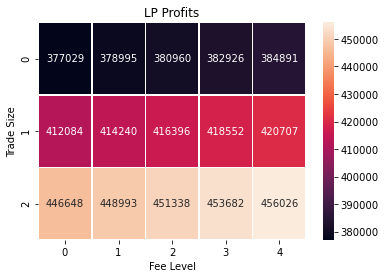

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix, linewidth=0.5, annot=True, fmt="d")
ax.set_title("LP Profits")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

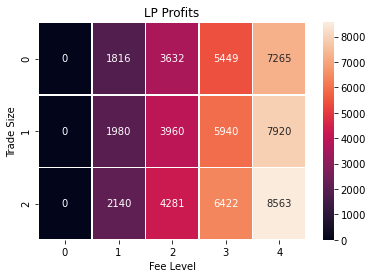

In [8]:
#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix1, linewidth=0.5, annot=True, fmt="d")
ax.set_title("LP Profits")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

In [9]:
matrix_ror

array([[2513, 2526, 2539, 2552, 2565],
       [2747, 2761, 2775, 2790, 2804],
       [2977, 2993, 3008, 3024, 3040]])

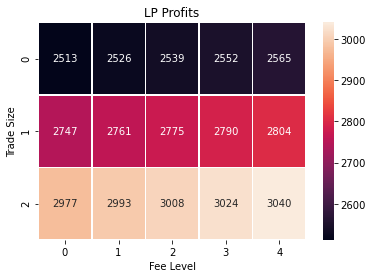

In [10]:
#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix_ror, linewidth=0.5, annot=True, fmt="d")
ax.set_title("LP Profits")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

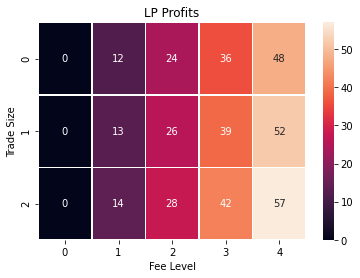

In [11]:
#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix_ror1, linewidth=0.5, annot=True, fmt="d")
ax.set_title("LP Profits")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

In [12]:
profit_results2['val_pool'].iloc[0]

4634230.45587282

In [13]:
profit_results3['val_pool'].iloc[0]

4666497.23827592

In [14]:
profit_results2['pool_val'].iloc[0]

5008573.100323565

In [15]:
profit_results3['pool_val'].iloc[0]

5000009.601151586

In [16]:
agent_d['LP1']['omniR1']

1000000

[0]


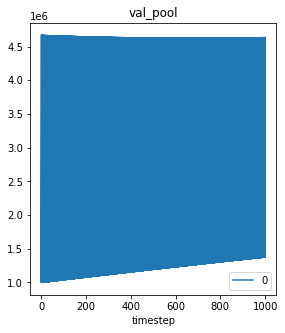

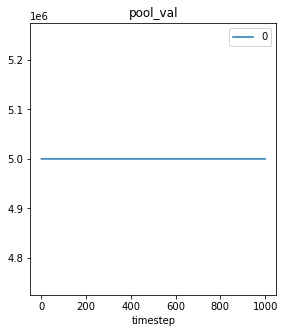

In [17]:
from model import plot_utils as pu
varlist = ['val_pool', 'pool_val']
dataframe = profit_results[profit_results['simulation'] == 0]
pu.plot_vars(dataframe, varlist)

## Merge Results

In [18]:
        profit_results = pd.merge(agent_df, rdf, how="inner", on=["timestep", "simulation", "run", "subset", "substep"])
        profit_results['val_pool'] = profit_results.apply(lambda x: processing.val_pool(x), axis=1)
        profit_sim0 = profit_results.apply(lambda x: processing.val_pool(x), axis=1)

In [19]:
profit_results

,simulation,subset,run,substep,timestep,agent_label,q,s-0,s-1,s-2,...,D,T,H,token_list-0,token_list-1,token_list-2,fee_assets,fee_HDX,n,val_pool
0,0,0,1,3,1,Trader,1000000.00,0,0,0,...,0.00,None,None,R1,R2,R3,0.00,0.00,3,4666533.45
1,0,0,1,3,1,LP1,0.00,1000000,0,0,...,0.00,None,None,R1,R2,R3,0.00,0.00,3,1999600.05
2,0,0,1,3,1,LP2,0.00,0,1500000,0,...,0.00,None,None,R1,R2,R3,0.00,0.00,3,1000399.98
3,0,0,1,3,1,LP3,0.00,0,0,2000000,...,0.00,None,None,R1,R2,R3,0.00,0.00,3,2000000.00
4,0,0,1,3,2,Trader,1000000.00,0,0,0,...,0.00,None,None,R1,R2,R3,0.00,0.00,3,4666400.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,14,0,1,3,999,LP3,0.00,0,0,2000000,...,0.00,None,None,R1,R2,R3,0.04,0.00,3,2000000.00
59996,14,0,1,3,1000,Trader,1000000.00,0,0,0,...,0.00,None,None,R1,R2,R3,0.04,0.00,3,4634230.46
59997,14,0,1,3,1000,LP1,0.00,1000000,0,0,...,0.00,None,None,R1,R2,R3,0.04,0.00,3,1584203.59
59998,14,0,1,3,1000,LP2,0.00,0,1500000,0,...,0.00,None,None,R1,R2,R3,0.04,0.00,3,1456516.45


In [20]:
#profit_results1 = profit_results[profit_results['simulation'] == sim_nr]
#profit_results2 = profit_results1[profit_results1['timestep'] == total_timesteps]
#profit_results2['val_pool'].iloc[0]

In [21]:
#print(profit_results.columns)

In [22]:
#profit_sim0

In [23]:
profit_results1

,simulation,subset,run,substep,timestep,agent_label,q,s-0,s-1,s-2,...,H,token_list-0,token_list-1,token_list-2,fee_assets,fee_HDX,n,val_pool,val_hold,pool_val
56000,14,0,1,3,1,Trader,1000000.00,0,0,0,...,None,R1,R2,R3,0.04,0.00,3,4666497.24,4666506.75,5000009.60
56001,14,0,1,3,1,LP1,0.00,1000000,0,0,...,None,R1,R2,R3,0.04,0.00,3,1999520.07,1999520.09,5000009.60
56002,14,0,1,3,1,LP2,0.00,0,1500000,0,...,None,R1,R2,R3,0.04,0.00,3,1000489.57,1000480.00,5000009.60
56003,14,0,1,3,1,LP3,0.00,0,0,2000000,...,None,R1,R2,R3,0.04,0.00,3,2000000.00,2000000.00,5000009.60
56004,14,0,1,3,2,Trader,1000000.00,0,0,0,...,None,R1,R2,R3,0.04,0.00,3,4666328.15,4666347.01,5000019.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,14,0,1,3,999,LP3,0.00,0,0,2000000,...,None,R1,R2,R3,0.04,0.00,3,2000000.00,2000000.00,5008565.45
59996,14,0,1,3,1000,Trader,1000000.00,0,0,0,...,None,R1,R2,R3,0.04,0.00,3,4634230.46,4575998.97,5008573.10
59997,14,0,1,3,1000,LP1,0.00,1000000,0,0,...,None,R1,R2,R3,0.04,0.00,3,1584203.59,1594387.76,5008573.10
59998,14,0,1,3,1000,LP2,0.00,0,1500000,0,...,None,R1,R2,R3,0.04,0.00,3,1456516.45,1472416.83,5008573.10


In [24]:
profit_results2

,simulation,subset,run,substep,timestep,agent_label,q,s-0,s-1,s-2,...,H,token_list-0,token_list-1,token_list-2,fee_assets,fee_HDX,n,val_pool,val_hold,pool_val
59996,14,0,1,3,1000,Trader,1000000.00,0,0,0,...,None,R1,R2,R3,0.04,0.00,3,4634230.46,4575998.97,5008573.10
59997,14,0,1,3,1000,LP1,0.00,1000000,0,0,...,None,R1,R2,R3,0.04,0.00,3,1584203.59,1594387.76,5008573.10
59998,14,0,1,3,1000,LP2,0.00,0,1500000,0,...,None,R1,R2,R3,0.04,0.00,3,1456516.45,1472416.83,5008573.10
59999,14,0,1,3,1000,LP3,0.00,0,0,2000000,...,None,R1,R2,R3,0.04,0.00,3,2000000.00,2000000.00,5008573.10


In [25]:
profit_results3

,simulation,subset,run,substep,timestep,agent_label,q,s-0,s-1,s-2,...,H,token_list-0,token_list-1,token_list-2,fee_assets,fee_HDX,n,val_pool,val_hold,pool_val
56000,14,0,1,3,1,Trader,1000000.00,0,0,0,...,None,R1,R2,R3,0.04,0.00,3,4666497.24,4666506.75,5000009.60
56001,14,0,1,3,1,LP1,0.00,1000000,0,0,...,None,R1,R2,R3,0.04,0.00,3,1999520.07,1999520.09,5000009.60
56002,14,0,1,3,1,LP2,0.00,0,1500000,0,...,None,R1,R2,R3,0.04,0.00,3,1000489.57,1000480.00,5000009.60
56003,14,0,1,3,1,LP3,0.00,0,0,2000000,...,None,R1,R2,R3,0.04,0.00,3,2000000.00,2000000.00,5000009.60


In [26]:
profit_results3['val_pool'].iloc[1]

1999520.0719913607

In [27]:
profit_results4 = profit_results3[profit_results3['agent_label'] == 'LP1']
profit_results4

,simulation,subset,run,substep,timestep,agent_label,q,s-0,s-1,s-2,...,H,token_list-0,token_list-1,token_list-2,fee_assets,fee_HDX,n,val_pool,val_hold,pool_val
56001,14,0,1,3,1,LP1,0.00,1000000,0,0,...,None,R1,R2,R3,0.04,0.00,3,1999520.07,1999520.09,5000009.60


In [28]:
profit_results4['val_pool'].iloc[0]

1999520.0719913607

In [29]:
profit_results5['val_pool'].iloc[0]

1000489.5746484005


var_list = ['R', 'Q', 'A', 'D']
plot_vars(rdf, var_list)

## Fee Analysis

In [30]:
rdf

,R-0,R-1,R-2,Q-0,Q-1,Q-2,S-0,S-1,S-2,A-0,...,token_list-1,token_list-2,fee_assets,fee_HDX,n,simulation,subset,run,substep,timestep
3,1000100,1499700.09,2000000,1999800.02,1000199.98,2000000,1000000,1500000,2000000,0,...,R2,R3,0.00,0.00,3,0,0,1,3,1
6,1000200,1499400.36,2000000,1999600.08,1000399.92,2000000,1000000,1500000,2000000,0,...,R2,R3,0.00,0.00,3,0,0,1,3,2
9,1000300,1499100.81,2000000,1999400.18,1000599.82,2000000,1000000,1500000,2000000,0,...,R2,R3,0.00,0.00,3,0,0,1,3,3
12,1000400,1498801.44,2000000,1999200.32,1000799.68,2000000,1000000,1500000,2000000,0,...,R2,R3,0.00,0.00,3,0,0,1,3,4
15,1000500,1498502.25,2000000,1999000.50,1000999.50,2000000,1000000,1500000,2000000,0,...,R2,R3,0.00,0.00,3,0,0,1,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45002,1119520,1246516.20,2000000,1786479.92,1222062.55,2000000,1000000,1500000,2000000,0,...,R2,R3,0.04,0.00,3,14,0,1,3,996
45005,1119640,1246328.74,2000000,1786288.45,1222261.68,2000000,1000000,1500000,2000000,0,...,R2,R3,0.04,0.00,3,14,0,1,3,997
45008,1119760,1246141.38,2000000,1786097.02,1222460.77,2000000,1000000,1500000,2000000,0,...,R2,R3,0.04,0.00,3,14,0,1,3,998
45011,1119880,1245954.11,2000000,1785905.63,1222659.81,2000000,1000000,1500000,2000000,0,...,R2,R3,0.04,0.00,3,14,0,1,3,999


In [31]:
print(rdf.columns)

Index(['R-0', 'R-1', 'R-2', 'Q-0', 'Q-1', 'Q-2', 'S-0', 'S-1', 'S-2', 'A-0',
       'A-1', 'A-2', 'B-0', 'B-1', 'B-2', 'D', 'T', 'H', 'token_list-0',
       'token_list-1', 'token_list-2', 'fee_assets', 'fee_HDX', 'n',
       'simulation', 'subset', 'run', 'substep', 'timestep'],
      dtype='object')


In [32]:
print(rdf.keys)

<bound method NDFrame.keys of            R-0        R-1      R-2        Q-0        Q-1      Q-2      S-0  \
3      1000100 1499700.09  2000000 1999800.02 1000199.98  2000000  1000000   
6      1000200 1499400.36  2000000 1999600.08 1000399.92  2000000  1000000   
9      1000300 1499100.81  2000000 1999400.18 1000599.82  2000000  1000000   
12     1000400 1498801.44  2000000 1999200.32 1000799.68  2000000  1000000   
15     1000500 1498502.25  2000000 1999000.50 1000999.50  2000000  1000000   
...        ...        ...      ...        ...        ...      ...      ...   
45002  1119520 1246516.20  2000000 1786479.92 1222062.55  2000000  1000000   
45005  1119640 1246328.74  2000000 1786288.45 1222261.68  2000000  1000000   
45008  1119760 1246141.38  2000000 1786097.02 1222460.77  2000000  1000000   
45011  1119880 1245954.11  2000000 1785905.63 1222659.81  2000000  1000000   
45014  1120000 1245766.95  2000000 1785714.29 1222858.81  2000000  1000000   

           S-1      S-2  A-0  ...

In [33]:
agent_df

,simulation,subset,run,substep,timestep,agent_label,q,s-0,s-1,s-2,r-0,r-1,r-2,p-0,p-1,p-2
12,0,0,1,3,1,Trader,1000000.00,0,0,0,999900,1000299.91,1000000,0.00,0.00,0.00
13,0,0,1,3,1,LP1,0.00,1000000,0,0,0,0.00,0,2.00,0.00,0.00
14,0,0,1,3,1,LP2,0.00,0,1500000,0,0,0.00,0,0.00,0.67,0.00
15,0,0,1,3,1,LP3,0.00,0,0,2000000,0,0.00,0,0.00,0.00,1.00
24,0,0,1,3,2,Trader,1000000.00,0,0,0,999800,1000599.64,1000000,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180047,14,0,1,3,999,LP3,0.00,0,0,2000000,0,0.00,0,0.00,0.00,1.00
180056,14,0,1,3,1000,Trader,1000000.00,0,0,0,880000,1254233.05,1000000,0.00,0.00,0.00
180057,14,0,1,3,1000,LP1,0.00,1000000,0,0,0,0.00,0,2.00,0.00,0.00
180058,14,0,1,3,1000,LP2,0.00,0,1500000,0,0,0.00,0,0.00,0.67,0.00


In [34]:
agent_df.query('agent_label=="LP1"')

,simulation,subset,run,substep,timestep,agent_label,q,s-0,s-1,s-2,r-0,r-1,r-2,p-0,p-1,p-2
13,0,0,1,3,1,LP1,0.00,1000000,0,0,0,0.00,0,2.00,0.00,0.00
25,0,0,1,3,2,LP1,0.00,1000000,0,0,0,0.00,0,2.00,0.00,0.00
37,0,0,1,3,3,LP1,0.00,1000000,0,0,0,0.00,0,2.00,0.00,0.00
49,0,0,1,3,4,LP1,0.00,1000000,0,0,0,0.00,0,2.00,0.00,0.00
61,0,0,1,3,5,LP1,0.00,1000000,0,0,0,0.00,0,2.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180009,14,0,1,3,996,LP1,0.00,1000000,0,0,0,0.00,0,2.00,0.00,0.00
180021,14,0,1,3,997,LP1,0.00,1000000,0,0,0,0.00,0,2.00,0.00,0.00
180033,14,0,1,3,998,LP1,0.00,1000000,0,0,0,0.00,0,2.00,0.00,0.00
180045,14,0,1,3,999,LP1,0.00,1000000,0,0,0,0.00,0,2.00,0.00,0.00


## How to metric

In [35]:
rdf.loc[(rdf['simulation'] == 0) & (rdf['timestep'] == 1000)]['R-1']

3000   1269230.77
Name: R-1, dtype: float64

In [36]:
#import pandas as pd
#rdf.get_value('simulation' == 0 )]
rdf1 = rdf[rdf["simulation"] == 0]
rdf2 = rdf1[rdf1["timestep"] == 1000]
x_0 = rdf2['R-0'].iloc[0]
x_0


1100000

In [37]:
rdf.loc[(rdf['simulation'] == 1) & (rdf['timestep'] == 1000)]['R-1']

6001   1251879.70
Name: R-1, dtype: float64

In [38]:
rdf.loc[(rdf['simulation'] == 2) & (rdf['timestep'] == 1000)]['R-1']

9002   1235294.12
Name: R-1, dtype: float64

In [39]:
rdf.loc[(rdf['simulation'] == 3) & (rdf['timestep'] == 1000)]['R-1']

12003   1271518.95
Name: R-1, dtype: float64

In [40]:
rdf.loc[(rdf['simulation'] == 0) & (rdf['timestep'] == 1)]['R-1']

3   1499700.09
Name: R-1, dtype: float64

In [41]:
rdf.loc[(rdf['simulation'] == 1) & (rdf['timestep'] == 1)]['R-1']

3004   1499670.11
Name: R-1, dtype: float64

In [42]:
rdf.loc[(rdf['simulation'] == 2) & (rdf['timestep'] == 1)]['R-1']

6005   1499640.13
Name: R-1, dtype: float64

In [43]:
rdf.loc[(rdf['simulation'] == 3) & (rdf['timestep'] == 1)]['R-1']

9006   1499703.09
Name: R-1, dtype: float64

### Calculate change in pool value

#### R-0

In [44]:
rdf1 = rdf[rdf["simulation"] == 0]
rdf2 = rdf1[rdf1["timestep"] == 1000]
r0_1 = rdf2['R-0'].iloc[0]
r0_1

1100000

In [45]:
rdf1 = rdf[rdf["simulation"] == 0]
rdf2 = rdf1[rdf1["timestep"] == 1]
r0_0 = rdf2['R-0'].iloc[0]
r0_0

1000100

In [46]:
profit_sim0_r0 = r0_1 - r0_0
profit_sim0_r0

99900

#### R-1

In [47]:
rdf1 = rdf[rdf["simulation"] == 0]
rdf2 = rdf1[rdf1["timestep"] == 1000]
r1_1 = rdf2['R-1'].iloc[0]
r1_1

1269230.7692307646

In [48]:
rdf1 = rdf[rdf["simulation"] == 0]
rdf2 = rdf1[rdf1["timestep"] == 1]
r1_0 = rdf2['R-1'].iloc[0]
r1_0

1499700.0899730083

In [49]:
profit_sim0_r1 = r1_1 - r1_0
profit_sim0_r1

-230469.32074224367

#### Total pool value

In [50]:
profit_sim0_r1 + profit_sim0_r0

-130569.32074224367

## How to heatmap

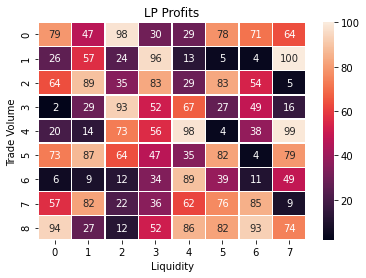

In [51]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

# set variables & parameters

fee_level = 0.03
# uniform_data = np.random.rand(10, 12)
#trade_volume = {'10': 0.5, '20': 0.6}
#liquidity = {'1000': 0.5, '2000': 0.6}
trade_volume = (50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000)
liquidity = (100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000)

#create matrix for comparison
m=len(trade_volume)
n=len(liquidity)
matrix = np.ndarray(shape = (m,n), dtype = int)

# index matrix
#better_index = ["X1", "X2", "Y1", "Y2", "Y3"]
#matrix.index = better_index

# fill in matrix with calculation results
for i in range(len(liquidity)):
    for j in range(len(trade_volume)):
        matrix[j][i] = np.random.randint(1, 100 + 1)




#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix, linewidth=0.5, annot=True, fmt="d")
ax.set_title("LP Profits")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Liquidity')
ax.set_ylabel('Trade Volume')
plt.show()

In [52]:
matrix

array([[ 79,  47,  98,  30,  29,  78,  71,  64],
       [ 26,  57,  24,  96,  13,   5,   4, 100],
       [ 64,  89,  35,  83,  29,  83,  54,   5],
       [  2,  29,  93,  52,  67,  27,  49,  16],
       [ 20,  14,  73,  56,  98,   4,  38,  99],
       [ 73,  87,  64,  47,  35,  82,   4,  79],
       [  6,   9,  12,  34,  89,  39,  11,  49],
       [ 57,  82,  22,  36,  62,  76,  85,   9],
       [ 94,  27,  12,  52,  86,  82,  93,  74]])

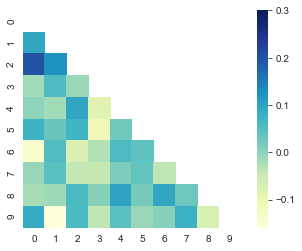

In [53]:
corr = np.corrcoef(np.random.randn(10, 200))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True,  cmap="YlGnBu")
    plt.show()

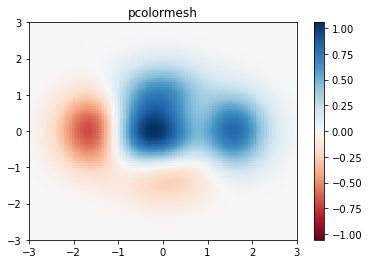

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

z = (1 - x / 2. + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()

fig, ax = plt.subplots()

c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

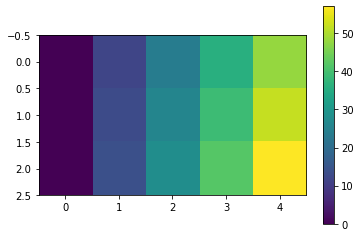

In [55]:
import matplotlib.pyplot as plt
import numpy as np


def heatmap2d(arr: np.ndarray):
    plt.imshow(arr, cmap='viridis')
    plt.colorbar()
    plt.show()


test_array = np.arange(100 * 100).reshape(100, 100)
heatmap2d(matrix_ror1)

In [56]:
trade_volume

(50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000)